In [1]:
import sys
sys.path.append("../")

In [2]:
import numpy as np
from training import protobuf_message_module
from godot_gym_api import GodotClient
from environments.enums import Request
import math
import matplotlib.pyplot as plt

In [3]:
config = {
    "agent": {
        "car": {
            "max_steering_angle": 0.2,
            "max_engine_force": 100,
        }
    },
    "environment": {
        "repeat_action": 4,
    }
}

In [4]:
ADDRESS = "localhost"
PORT = 9090
client = GodotClient(protobuf_message_module, (ADDRESS, PORT), chunk_size=65536)
_ = client.configure(config) # Response is meaningless

Waiting for Godot server launch.
Connection is established.


In [5]:
action = {
    "steering_delta": 0,
    "engine_force_delta": 1, #choice([-1/50, 1/50]),
}

In [6]:
def step(action):
    requested_observation = {
        "agent": [
            # Request.CAMERA,
            # Request.LIDAR,
            # Request.IS_CRASHED,
            # Request.WHEEL_POSITION,
            Request.PARKING_SENSORS,
            # Request.SPEED,
            Request.GLOBAL_COORDINATES,
        ]
    }
    current_state = client.step(action, requested_observation)
    agent_state = current_state["agent"]
    global_coordinates = agent_state["global_coordinates"]
    parking_sensors = {k: agent_state["parking_sensors"][k].distance[-1] for k in agent_state["parking_sensors"].keys()}
    return global_coordinates, parking_sensors

In [7]:
global_coordinates = []
parking_sensors = []
for _ in range(120):
    global_coordinates_, parking_sensors_ = step(action)
    global_coordinates.append(global_coordinates_)
    parking_sensors.append(parking_sensors_)

In [28]:
MAX_SENSOR_DIST = 2
zs = []
xs = []
cs = []
for sensor_data, car_pos in zip(parking_sensors, global_coordinates):
    x = car_pos.x
    z = car_pos.z
    rot_y = car_pos.rot_y # degrees
    angle_mapping = {
        "Right": 180,
        "FrontRight": 225,
        "Front": 270,
        "FrontLeft": 315,
        "Left": 0,
        "RearLeft": 45,
        "Rear": 90,
        "RearRight": 135,
    }
    shift_mapping = {
        "Right": {"x": -0.825, "z": 0,},
        "FrontRight": {"x": -0.825, "z": 2.04},
        "Front": {"x": 0, "z": 2.04},
        "FrontLeft": {"x": 0.825, "z": 2.04},
        "Left": {"x": 0.825, "z": 0},
        "RearLeft": {"x": 0.825, "z": -2.04},
        "Rear": {"x": 0, "z": -2.04},
        "RearRight": {"x": -0.825, "z": -2.04},
    }
    color_mapping = {
        "Right": 0,
        "FrontRight": 1,
        "Front": 2,
        "FrontLeft": 3,
        "Left": 4,
        "RearLeft": 5,
        "Rear": 6,
        "RearRight": 7,
    }
    for key, dist in sensor_data.items():
        if dist < MAX_SENSOR_DIST and key=="FrontRight" or key=="FrontLeft":
            angle = angle_mapping[key] + rot_y - 180  # Check why car orientation is not consisent with its direction of driving
            dz = math.cos(math.radians(angle)) * dist
            dx = math.sin(math.radians(angle)) * dist
            zs.append(z + shift_mapping[key]["z"] - dz)
            xs.append(x + shift_mapping[key]["x"] - dx)
            cs.append(color_mapping[key])

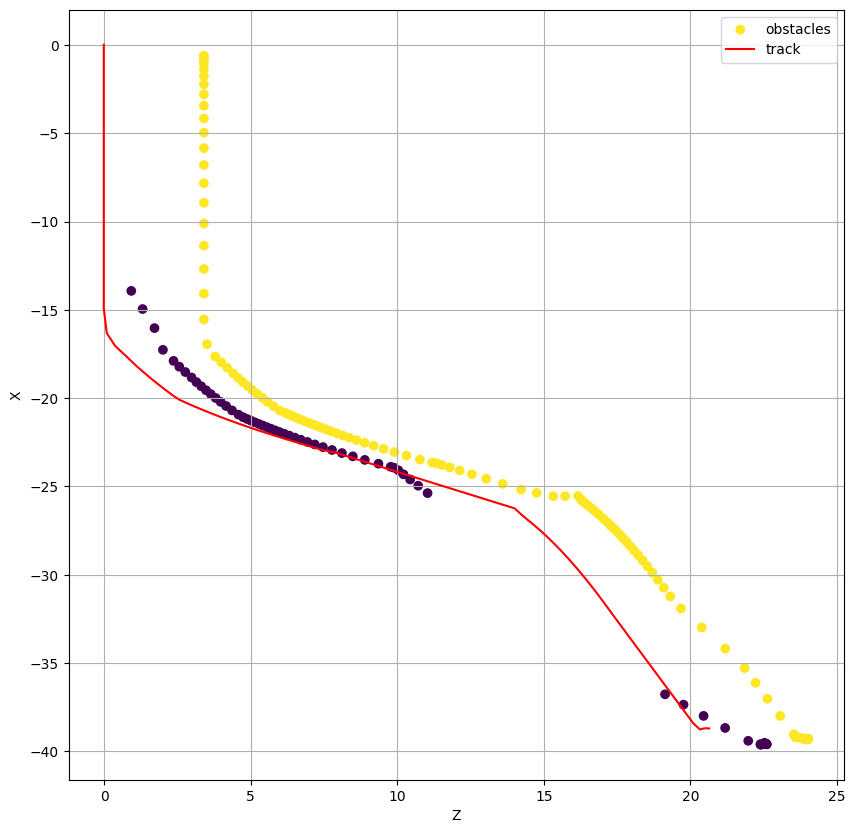

In [29]:
fig = plt.figure(figsize=(10,10))
plt.xlabel("Z")
plt.ylabel("X")
plt.scatter(zs, xs, label="obstacles", c=cs)
plt.plot([p.z for p in global_coordinates], [p.x for p in global_coordinates], color="red", label="track")
# plt.arrow(0, 0, 10, 10, head_width=2, overhang=1)
plt.legend()
plt.grid()
plt.show()